# GradientBoosting

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

## Read dataset

In [2]:
data_train = pd.read_csv('processed_training.csv')
data_test = pd.read_csv('processed_test.csv')
data_train.head()

,attendance,is_federal_holiday,venue,on_grass,temperature,wind_speed,team1_name,team1_pre_win,team1_pre_loss,team1_pre_win_pct,...,weather_Rain,weather_Sunny,season_type,season,home_team_avg_att_last_year,start_hour,start_hour_label_afternoon,start_hour_label_evening,start_hour_label_night,start_hour_label_noon
0,35055,0,Wrigley Field,1,-2.786672,-0.093090,STL,-1.62645,-1.654514,0.0,...,0,1,regular,2015,0.345307,19,0,1,0,0
1,49043,0,Chase Field,1,0.705205,-0.093090,SFG,-1.62645,-1.654514,0.0,...,0,1,regular,2015,-0.573314,19,0,1,0,0
2,43633,0,Great American Ball Park,1,-0.521670,1.490839,PIT,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.066649,16,1,0,0,0
3,45030,0,Comerica Park,1,-2.031671,-0.489072,MIN,-1.62645,-1.654514,0.0,...,0,0,regular,2015,0.766348,13,0,0,0,1
4,43753,0,Minute Maid Park,1,0.516455,1.292848,CLE,-1.62645,-1.654514,0.0,...,0,0,regular,2015,-1.084575,18,0,1,0,0


In [4]:
data_train.drop(['venue', 'start_hour'], axis=1, inplace=True)
data_test.drop(['venue', 'start_hour'], axis=1, inplace=True)

In [5]:
data_train = pd.get_dummies(data_train, columns=['team1_name'])
data_test = pd.get_dummies(data_test, columns=['team1_name'])

In [6]:
data_train = pd.get_dummies(data_train, columns=['team2_name'])
data_test = pd.get_dummies(data_test, columns=['team2_name'])

In [7]:
data_train = pd.get_dummies(data_train, columns=['season_type'])
data_test = pd.get_dummies(data_test, columns=['season_type'])

In [3]:
train_cols = data_train.columns.tolist()
data_test = data_test[train_cols].copy()

In [8]:
print(set(data_train.columns) - set(data_test.columns))
print(set(data_test.columns) - set(data_train.columns))

set()

In [9]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)

In [10]:
y_train = data_train['attendance'].to_numpy()
y_test = data_test['attendance'].to_numpy()

data_train.drop(['attendance'], axis=1, inplace=True)
data_test.drop(['attendance'], axis=1, inplace=True)

x_train = data_train.to_numpy()
x_test = data_test.to_numpy()

print(x_train.shape)

(12270, 273)


## kfold

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
#  'loss': ['squared_error', 'absolute_error', 'huber', 'quantile']
parameters = {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.1, 0.05, 0.01, 0.001], 'subsample': [0.5, 0.8, 1], 'max_depth': [3, 5, 8, 10]}
model = GradientBoostingRegressor(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring=scoring, refit='neg_root_mean_squared_error')
clf.fit(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
print("Best estimators:", clf.best_estimator_)
print("Best parameters:", clf.best_params_)

In [ ]:
df_res = pd.DataFrame(data=clf.cv_results_)
df_res.head()

## Train with best params

In [22]:
gb = GradientBoostingRegressor(colsample_bytree= 0.7, learning_rate=0.1, max_depth= 8, n_estimators=1000)
gb = gb.fit(x_train, y_train)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
train_predict = gb.predict(x_train)
print("Train MSE:", mean_squared_error(y_train, train_predict))
print("Train RMSE:", mean_squared_error(y_train, train_predict, squared=False))
print("Train MAE:", mean_absolute_error(y_train, train_predict))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_predict))

Train MSE: 129543.60382886251
Train RMSE: 359.9216634614573
Train MAE: 254.58731911308706
Train MAPE: 0.010110836339593494


Text(0.5, 0, 'Xgboost Feature Importance')

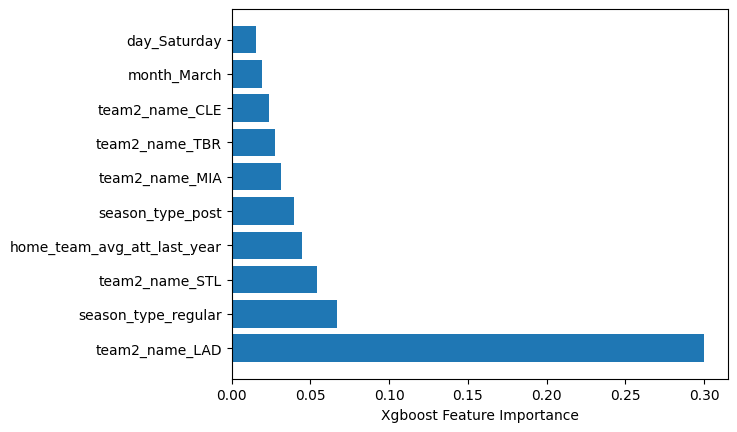

In [32]:
from matplotlib import pyplot as plt
num_features = 20
sorted_idx = gb.feature_importances_.argsort()[::-1][:num_features]
cols = data_train.columns
plt.barh(cols[sorted_idx][:num_features][::-1], gb.feature_importances_[sorted_idx][:num_features][::-1])
plt.xlabel("Feature Importance")

In [33]:
gb.feature_importances_[sorted_idx][:10]

array([0.2999713 , 0.06681152, 0.05383719, 0.04436452, 0.03940467,
       0.03115905, 0.0273303 , 0.02394587, 0.01922136, 0.01547278],
      dtype=float32)

## Testing set

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
y_pred = gb.predict(x_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Train MSE: 39782965.66595948
Train RMSE: 6307.373912014372
Train MAE: 4865.971954083589
Train MAPE: 0.24545172449712468


## Save model

In [ ]:
import pickle
from datetime import datetime
time = datetime.today().strftime('%Y%m%d_%H%M%S')
filename = f'./model/gradientboosting_model_{time}.sav'
cv_filename = f'./model/gradientboosting_model_{time}_cv.csv'
df_res.to_csv(cv_filename, index=False)
pickle.dump(gb, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))